# Análisis del dataset SIAR



In [1]:
import pandas as pd
from datetime import datetime
import glob
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sys 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_decision_regions
import matplotlib.colors as mcolors
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 1. Filtrado de Columnas

El algoritmo guarda únicamente las columnas que son necesarias para el análisis.

In [29]:
def filtrar_columnas(file_path):
    try:
        
        df = pd.read_csv(file_path, sep=';', decimal=',', encoding='utf-16-le')
        
        # Filtramos las columnas que vamos a usar en el resto del código
        colums_requeridas = [
            'Fecha', 
            'Temp Media (ºC)', 
            'Hum Media (%)', 
            'Precipitación (mm)', 
            'Vel Viento (m/s)', 
            'Año'
        ]
        
            
        
        df_filtrado = df[colums_requeridas]
        
        # Guardamos e archivo
        df_filtrado.to_csv(file_path, sep=';', decimal=',', encoding='utf-16-le', index=False)
        
        print(df_filtrado.head())
        
    except Exception as e:
        print(f"Error:{e}")

# Ejecutar después de la fusión (Punto 1) pero antes de añadir estación (Punto 2)
filtrar_columnas('work.csv')

        Fecha  Temp Media (ºC)  Hum Media (%)  Precipitación (mm)  \
0  20/12/2021            59.14         134.68              376.40   
1  27/12/2021             8.76          89.36                0.61   
2  01/01/2022             5.62          87.04                0.00   
3  03/01/2022             4.40          86.61               12.04   
4  10/01/2022             3.47          81.11                0.41   

   Vel Viento (m/s)   Año  
0              1.02  2021  
1              1.66  2021  
2              0.82  2022  
3              1.37  2022  
4              1.00  2022  


## 2. Añadir Estación del Año

Después de limpiar las columnas no necesarias, este algoritmo calcula la estación del año en base a la columna fecha en la que se tomó la medición.

In [30]:
# Determinamos la estación del año en base a la fecha
def obtener_estacion_rango(date_obj):
   
    mes_dia = (date_obj.month, date_obj.day)
    
    # Primavera: 
    if (3, 21) <= mes_dia <= (6, 20):
        return "primavera"
    # Verano: 
    elif (6, 21) <= mes_dia <= (9, 22):
        return "verano"
    # Otoño: 
    elif (9, 23) <= mes_dia <= (12, 20):
        return "otoño"
    # Invierno: 
    else:
        return "invierno"

def procesar_csv_estacion(archivo_entrada, archivo_salida):
    try:
       
        # Carga del csv
        df = pd.read_csv(archivo_entrada, sep=';', decimal=',', encoding='utf-16-le')
        
        # Convertir a datetime la columna fecha                        
        df['Fecha_date'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')
        
        # Aplicamos la función de obtener estación a la columna de fecha convertida y generamos la columna estacion_anho
        df['estacion_anho'] = df['Fecha_date'].apply(obtener_estacion_rango)
        
    
        df.drop(columns=['Fecha_date'], inplace=True)
        
        # Guardar resultado
        df.to_csv(archivo_salida, sep=';', decimal=',', encoding='utf-16-le', index=False)
        print(f"Archivo {archivo_salida} creado exitosamente")
        
    except Exception as e:
        print(f"Error {e}")

archivo_entrada = "work.csv"
archivo_salida = "work_with_season.csv"
procesar_csv_estacion(archivo_entrada, archivo_salida)

Archivo work_with_season.csv creado exitosamente


## 3. Limpieza de los datos

Este algoritmo elimina outliers y sustituye valores nulos por la media de su columna.

In [33]:
df = pd.read_csv('work_with_season.csv', sep=';', decimal=',', encoding='utf-16-le')

In [34]:
# --- 1) Nulos por columna ---
nulos = df.isna().sum()
pct_nulos = df.isna().mean() * 100
reporte_nulos = pd.DataFrame({
    'n_nulos': nulos,
    '%_nulos': pct_nulos.round(2)
}).sort_values('%_nulos', ascending=False)


# --- 2) Estadísticos para columnas numéricas ---
num_columnas = df.select_dtypes(include='number').columns
stats_num = pd.DataFrame({
    'min': df[num_columnas].min(),
    'max': df[num_columnas].max(),
    'media': df[num_columnas].mean(),
    'mediana': df[num_columnas].median(),
    'n': df[num_columnas].count(),
    'std': df[num_columnas].std()
}).round(4)

# --- 3) Mostrar ---
print("\n=== NULOS POR COLUMNA ===")
print(reporte_nulos)

print("\n=== ESTADÍSTICOS NUMÉRICOS ===")
print(stats_num)


=== NULOS POR COLUMNA ===
                    n_nulos  %_nulos
Temp Media (ºC)          30     2.19
Hum Media (%)            30     2.19
Precipitación (mm)       30     2.19
Fecha                     0     0.00
Vel Viento (m/s)          0     0.00
Año                       0     0.00
estacion_anho             0     0.00

=== ESTADÍSTICOS NUMÉRICOS ===
                        min      max      media  mediana     n      std
Temp Media (ºC)        0.42    69.80    17.3731    15.23  1341  12.0680
Hum Media (%)         21.10   149.16    67.8232    69.04  1341  22.2305
Precipitación (mm)     0.00   498.89    25.4398     1.37  1341  84.5375
Vel Viento (m/s)       0.15     3.98     1.1453     1.06  1371   0.5576
Año                 2021.00  2025.00  2023.5383  2024.00  1371   1.1343


In [35]:
def limpieza_de_datos(file_path):
    try:
        
        df = pd.read_csv(file_path, sep=';', decimal=',', encoding='utf-16-le')
        contador_inicial = len(df)
        print(f"Filas iniciales: {contador_inicial}")
        
        # Sustituimos nulos por la media de la collumna
        columnas = ['Temp Media (ºC)', 'Hum Media (%)', 'Precipitación (mm)']
        for col in columnas:
            if df[col].isnull().any():
                valor_medio = df[col].mean()
                df[col] = df[col].fillna(valor_medio)
                print(f"Reemplazados nulos en '{col}' con la media: {valor_medio:.2f}")
        
        # Filtrar Temperatura (Eliminar > 50)
        df = df[df['Temp Media (ºC)'] <= 50]
        
        # Filtrar Humedad (Eliminar < 0 o > 100)
        df = df[(df['Hum Media (%)'] >= 0) & (df['Hum Media (%)'] <= 100)]
        
        # Filtrar Precipitación (Eliminar > 299)
        df = df[df['Precipitación (mm)'] <= 299]
        
        contador_final = len(df)
        print(f"Filas finales tras filtrado de outliers: {contador_final}")
        print(f"Outliers eliminados: {contador_inicial - contador_final}")
        
        # Guardar cambios
        df.to_csv(file_path, sep=';', decimal=',', encoding='utf-16-le', index=False)
        print(f"Archivo modificado {file_path}")
        
    except Exception as e:
        print(f"Error {e}")

limpieza_de_datos('work_with_season.csv')

Filas iniciales: 1371
Reemplazados nulos en 'Temp Media (ºC)' con la media: 17.37
Reemplazados nulos en 'Hum Media (%)' con la media: 67.82
Reemplazados nulos en 'Precipitación (mm)' con la media: 25.44
Filas finales tras filtrado de outliers: 1311
Outliers eliminados: 60
Archivo modificado work_with_season.csv


## 4. Contraste de Hipótesis

Análisis estadístico para comparar variables entre estaciones y años.

In [36]:
df = pd.read_csv('work_with_season.csv', sep=';', decimal=',', encoding='utf-16-le')

In [37]:
# --- 1) Nulos por columna ---
nulos = df.isna().sum()
pct_nulos = df.isna().mean() * 100
reporte_nulos = pd.DataFrame({
    'n_nulos': nulos,
    '%_nulos': pct_nulos.round(2)
}).sort_values('%_nulos', ascending=False)


# --- 2) Estadísticos para columnas numéricas ---
num_columnas = df.select_dtypes(include='number').columns
stats_num = pd.DataFrame({
    'min': df[num_columnas].min(),
    'max': df[num_columnas].max(),
    'media': df[num_columnas].mean(),
    'mediana': df[num_columnas].median(),
    'n': df[num_columnas].count(),
    'std': df[num_columnas].std()
}).round(4)

# --- 3) Mostrar ---
print("\n=== NULOS POR COLUMNA ===")
print(reporte_nulos)

print("\n=== ESTADÍSTICOS NUMÉRICOS ===")
print(stats_num)


=== NULOS POR COLUMNA ===
                    n_nulos  %_nulos
Fecha                     0      0.0
Temp Media (ºC)           0      0.0
Hum Media (%)             0      0.0
Precipitación (mm)        0      0.0
Vel Viento (m/s)          0      0.0
Año                       0      0.0
estacion_anho             0      0.0

=== ESTADÍSTICOS NUMÉRICOS ===
                        min      max      media    mediana     n      std
Temp Media (ºC)        0.42    32.63    15.4269    15.1000  1311   7.8077
Hum Media (%)         21.10    97.53    64.8976    67.8232  1311  17.4329
Precipitación (mm)     0.00   118.61     7.9942     1.2000  1311  13.6760
Vel Viento (m/s)       0.15     3.98     1.1453     1.0600  1311   0.5551
Año                 2021.00  2025.00  2023.5416  2024.0000  1311   1.1370


## Contraste de hipotesis:

In [7]:
# usamos la variable categórica estación ya calculada en el csv
df["estacion"] = df["estacion_anho"]

**Comparativa entre velocidad del viento de primavera y otoño**

Queremos ver si hay diferencias en la velocidad del viento promedia (en m/s) entre primavera y otoño. Para ello primero tenemos que ver si los datos se distribuyen siguiento una distribución normal en cada uno de los grupos: 

In [8]:
viento_prim = df[df["estacion"] == "primavera"]["Vel Viento (m/s)"]
viento_oto = df[df["estacion"] == "otoño"]["Vel Viento (m/s)"]

In [9]:
for nombre, datos in {
    "Primavera": viento_prim,
    "Otoño": viento_oto,
}.items():
    stat, p = shapiro(datos)
    print(f"{nombre}: p = {p:.4f}")

Primavera: p = 0.0000
Otoño: p = 0.0000


Obtenemos un p-valor inferior a 0.05, por lo que parece que los datos no son normales:

In [10]:
print('Viento promedio en primavera: ', viento_prim.mean())
print('Viento promedio en otoño: ', viento_oto.mean())

Viento promedio en primavera:  1.253720930232558
Viento promedio en otoño:  1.0262017804154302


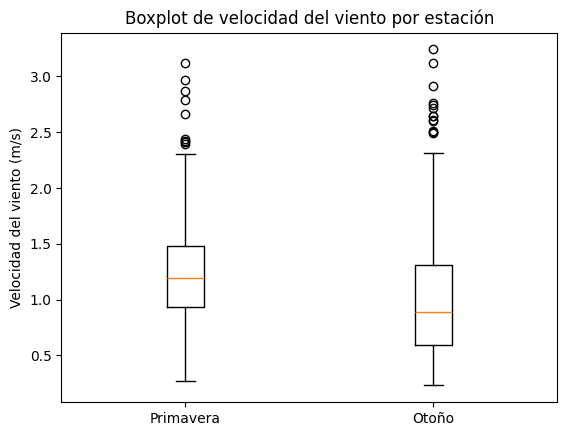

In [11]:
plt.boxplot([viento_prim, viento_oto], tick_labels=["Primavera", "Otoño"])
plt.ylabel("Velocidad del viento (m/s)")
plt.title("Boxplot de velocidad del viento por estación")
plt.show()

In [12]:
u_stat, p_value = mannwhitneyu(viento_prim, viento_oto, alternative="two-sided")

print("U =", u_stat)
print("p =", p_value)

U = 75891.5
p = 2.8617074241146357e-12


Hay diferencias estadísticamente signficativas, por lo que parece que la velocidad del viento es diferente entre primavera y otoño

**Comparativa entre temperatura de dos inviernos**

In [13]:
temp_22 = df[(df["Año"] == 2022) & (df["estacion"] == "invierno") ]["Temp Media (ºC)"]
temp_23 = df[(df["Año"] == 2023) & (df["estacion"] == "invierno")]["Temp Media (ºC)"]

In [14]:
for nombre, datos in {
    "Temp_invierno_22": temp_22,
    "Temp_invierno_23": temp_23,
}.items():
    stat, p = shapiro(datos)
    print(f"{nombre}: p = {p:.4f}")

Temp_invierno_22: p = 0.2670
Temp_invierno_23: p = 0.0002


In [15]:
print('Temperatura media en invierno 2022: ', temp_22.mean())
print('Temperatura media en invierno 2023: ', temp_23.mean())

Temperatura media en invierno 2022:  6.539615384615385
Temperatura media en invierno 2023:  6.415833333333333


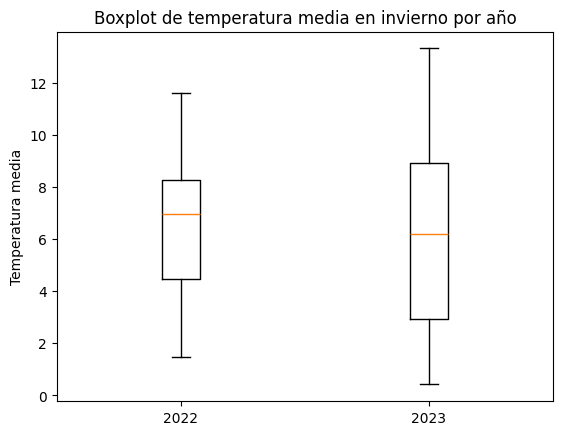

In [16]:
plt.boxplot([temp_22, temp_23], tick_labels=["2022", "2023"])
plt.ylabel("Temperatura media")
plt.title("Boxplot de temperatura media en invierno por año")
plt.show()

In [17]:
u_stat, p_value = mannwhitneyu(temp_22, temp_23, alternative="two-sided")

print("U =", u_stat)
print("p =", p_value)

U = 3565.0
p = 0.3335067335178904


No hay diferencias estadisticamente significativas, por lo que no podemos decir que haya diferencias en la temperatura promedio en invierno entre 2022 y 2023. 

## 5. Algoritmo dePredicción de Estación del año con KNN

Este algoritmo usa KNN para predecir la estación del año usando los datos meteorológicos.

Modelo entrenado con K=5
Precisión: 0.73

Reporte de la  Clasificación:
              precision    recall  f1-score   support

    invierno       0.77      0.74      0.76        74
       otoño       0.68      0.67      0.67        63
   primavera       0.62      0.72      0.67        65
      verano       0.88      0.79      0.83        73

    accuracy                           0.73       275
   macro avg       0.74      0.73      0.73       275
weighted avg       0.74      0.73      0.74       275



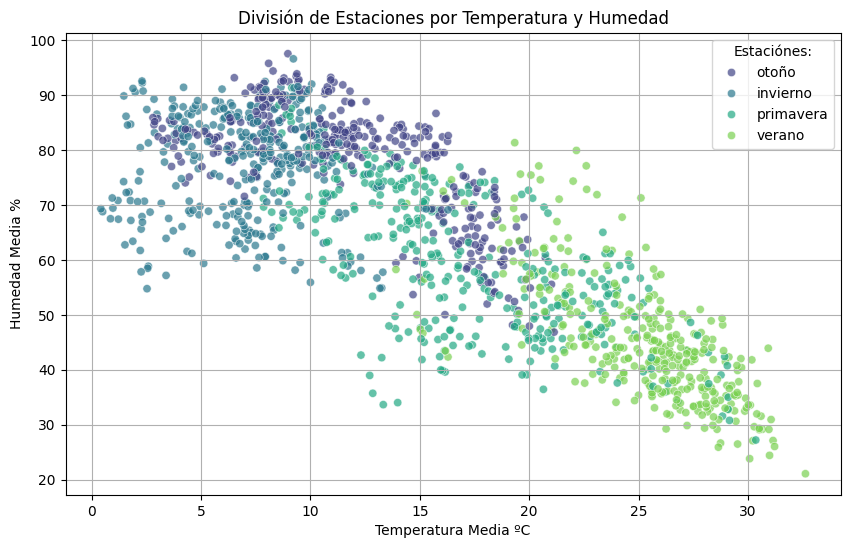


 Predicción para temperatura y humedad de 25 y 50
Predicción para 25.0ºC, 50.0%: verano
Probabilidad:
  invierno: 0.0%
  otoño: 0.0%
  primavera: 20.0%
  verano: 80.0%


In [18]:
def entrenamiento_knn(archivo_entrada):
    global df  
    global knn 
    global X_train
    global y_train
    global X_test
    global y_test
    try:
       
       
        #
        columnas_caracteristicas = ['Temp Media (ºC)', 'Hum Media (%)']
        columna_objetivo = 'estacion_anho'
        
        # Eliminar filas con valores que faltan
        df_filtrado = df.dropna(subset=columnas_caracteristicas + [columna_objetivo])
        
        
        # Guardamos en variable global
        df = df_filtrado.copy()
        

        X = df_filtrado[columnas_caracteristicas]
        y = df_filtrado[columna_objetivo]
        
        # Dividir datos de entranmiento y test 80/20
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Entrenamiento
        k = 5
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Evaluar
        y_pred = knn.predict(X_test)
        precision = accuracy_score(y_test, y_pred)
        
        print(f"Modelo entrenado con K={k}")
        print(f"Precisión: {precision:.2f}")
        print("\nReporte de la  Clasificación:")
        print(classification_report(y_test, y_pred))
        
        # Visualización
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=df_filtrado, 
            x='Temp Media (ºC)', 
            y='Hum Media (%)', 
            hue='estacion_anho', 
            palette='viridis',
            alpha=0.7
        )
        
        plt.title('División de Estaciones por Temperatura y Humedad')
        plt.xlabel('Temperatura Media ºC')
        plt.ylabel('Humedad Media %')
        plt.legend(title='Estaciónes:')
        plt.grid(True)
        plt.show()

        # Predicción de ejemplo (No interactiva)
        print("\n Predicción para temperatura y humedad de 25 y 50")
        temp = 25.0
        hum = 50.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pred = knn.predict([[temp, hum]])[0]
            probs = knn.predict_proba([[temp, hum]])[0]
        
        print(f"Predicción para {temp}ºC, {hum}%: {pred}")
        print("Probabilidad:")
        for class_name, prob in zip(knn.classes_, probs):
            print(f"  {class_name}: {prob*100:.1f}%")

    except Exception as e:
        print(f"error: {e}")

archivo_csv_knn = "work_with_season.csv"
entrenamiento_knn(archivo_csv_knn)

In [19]:
# Instalar mlxtend si no existe
!{sys.executable} -m pip install mlxtend --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


## 6. Visualización de las fronteras de decisión de la predicción de la estación con KNN

Visualización de fronteras de decisión de cuando se daría como resultado una estación u otra

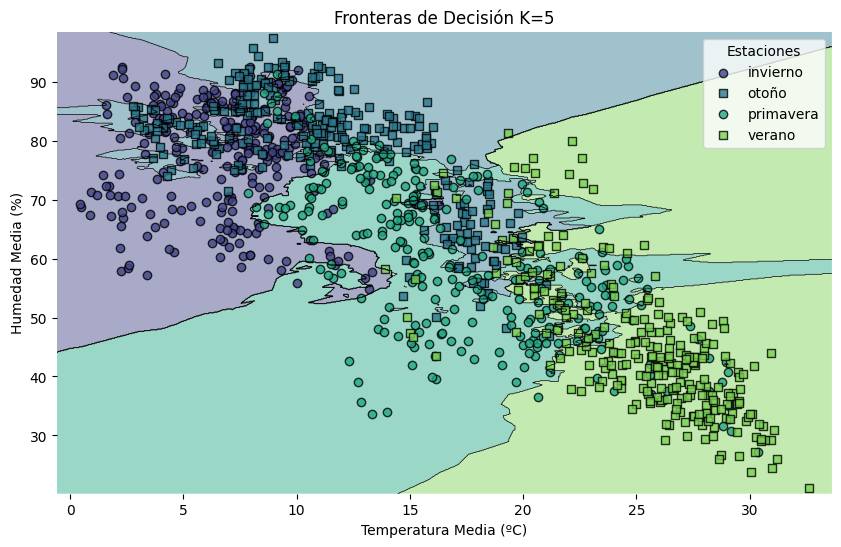

In [20]:

def fronteras_decision():
    global df
    global knn
    global X_train
    global y_train
    
    try:
     
        columnas_caracteristicas = ['Temp Media (ºC)', 'Hum Media (%)']
        columna_objetivo = 'estacion_anho'
        
        X = X_train[columnas_caracteristicas].values
       
        
        # mlxtend necesita etiquetas numéricas enteras
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)
        
        
        knn.fit(X, y_encoded)
        

        plt.figure(figsize=(10, 6))
        

        colors = sns.color_palette("viridis", n_colors=4)
        hex_colors = ",".join([mcolors.to_hex(c) for c in colors])
        
        plot_decision_regions(X, y_encoded, clf=knn, legend=2, colors=hex_colors, markers='o,o,o,o')
        
        plt.xlabel('Temperatura Media (ºC)')
        plt.ylabel('Humedad Media (%)')
        plt.title('Fronteras de Decisión K=5')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, le.classes_, title='Estaciones')
        
        plt.show()
      
        
    except Exception as e:
        print(f"Error {e}")

fronteras_decision()

## 7. Predicción de  la estación del año de manera no Supervisada (K-Means K=6)
El algoritmo usa la temperatura y humedad con kMeans y 6 clusters para mejorar la precisión

Mapeo Cluster -> Estación (K=6):
Cluster 0 -> verano
Cluster 1 -> primavera
Cluster 2 -> otoño
Cluster 3 -> primavera
Cluster 4 -> invierno
Cluster 5 -> verano

Precisión:: 56.36%

Reporte de Clasificación:
               precision    recall  f1-score   support

    invierno       0.90      0.35      0.50        74
       otoño       0.46      0.51      0.48        63
   primavera       0.40      0.55      0.46        65
      verano       0.71      0.84      0.77        73

    accuracy                           0.56       275
   macro avg       0.62      0.56      0.55       275
weighted avg       0.63      0.56      0.56       275



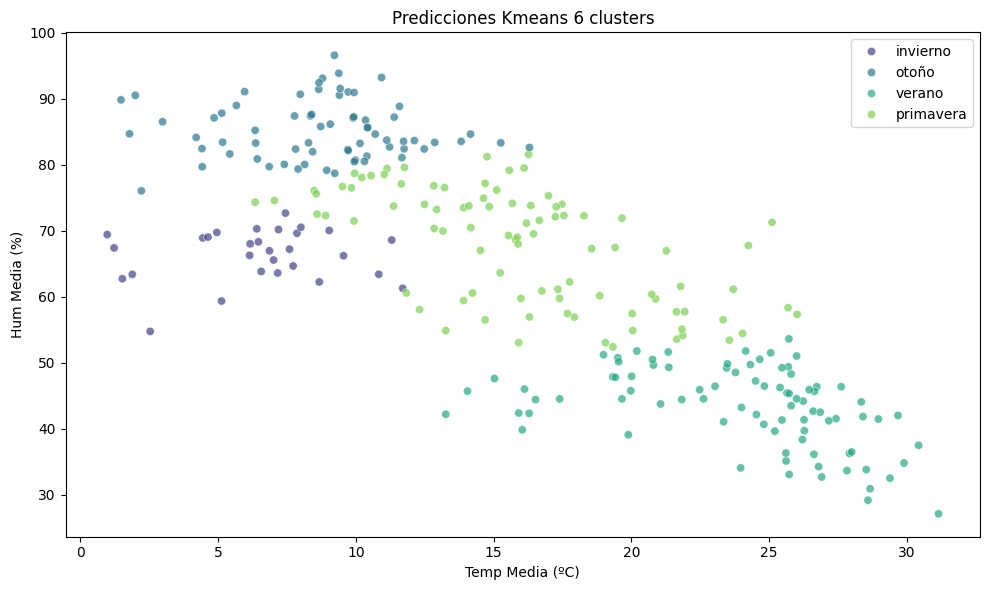

In [21]:

def cluster_kmeans():
    global X_train
    global X_test
    global y_test
    global df
    archivo_entrada = 'work_with_season.csv'
    
    try:
        
        
       

        
        
        # Train K-Means on Train Set (K=6 para mejorar detección de Invierno)
        kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
        kmeans.fit(X_train)
        
        # Map Clusters to Seasons (Semi-Supervised Labeling)
        train_labels = kmeans.labels_
        df_train_map = pd.DataFrame({'Cluster': train_labels, 'Season': y_train.values})
        
        cluster_map = {}
        print("Mapeo Cluster -> Estación (K=6):")
        for i in range(6):
            seasons_in_cluster = df_train_map[df_train_map['Cluster'] == i]['Season']
            if not seasons_in_cluster.empty:
                majority_season = seasons_in_cluster.mode()[0]
                cluster_map[i] = majority_season
                print(f"Cluster {i} -> {majority_season}")
            else:
                cluster_map[i] = "unknown"
        
        # Predict on Test Set
        test_cluster_ids = kmeans.predict(X_test)
        y_pred = [cluster_map[cid] for cid in test_cluster_ids]
        
        # Evaluation
        acc = accuracy_score(y_test, y_pred)
        print(f"\nPrecisión:: {acc:.2%}")
        
        # Classification Report
        print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
        
        # Visualization
        plt.figure(figsize=(10, 6))
        
        # Clusters Visualization
        palette = "viridis"
        # Filter palette to only used keys to avoid warnings if some season is missing
        sns.scatterplot(x=X_test['Temp Media (ºC)'], y=X_test['Hum Media (%)'], hue=y_pred, palette=palette, alpha=0.7)
        plt.title('Predicciones Kmeans 6 clusters')
        
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

cluster_kmeans()